## 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## 2. Keypoints using Mediapipe Holistic

In [6]:
mp_holistic = mp.solutions.holistic   # Holistic model
mp_drawing = mp.solutions.drawing_utils   # Công cụ để vẽ

In [7]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   # Color conversion
    image.flags.writeable = False                    # Hình ảnh không thể ghi vào
    results = model.process(image)                   # Prediction
    image.flags.writeable = True                     # Hình ảnh có thể ghi vào
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)   # Color conversion
    return image, results

In [33]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [37]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80, 110, 10),thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80, 256, 121),thickness=1,circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10),thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121),thickness=2,circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76),thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250),thickness=2,circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66),thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230),thickness=2,circle_radius=2)
                             )

In [ ]:
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # read feed
        ret, frame = cap.read()
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV feed', image)
    
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

In [51]:
draw_styled_landmarks(frame, results)

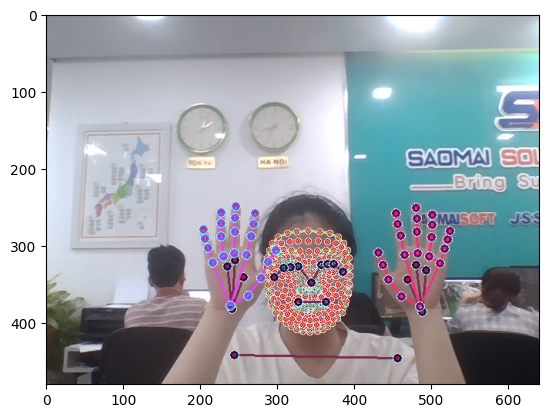

In [52]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 3. Extract Keypoint Values

In [53]:
len(results.pose_landmarks.landmark)

33

In [54]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [55]:
# flatten(): Làm phẳng mảng n chiều
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [61]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [62]:
extract_keypoints(results).shape     # 468*3 + 33*4 + 21*3 + 21*3

(1662,)

## 4. Setup Folder for Collection

In [ ]:
# Thư mục chứa dữ liệu
DATA_PATH = os.path.join('MP_Data')

# Các hành động muốn detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# 30 video của dữ liệu
no_sequences = 30
# Mỗi video có 30 frames
sequence_length = 30